In [1]:
import os
import time
import shelve
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
import matplotlib.pyplot as plt

In [2]:
def load_data(name):
    
    if name == 'mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif name == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        print('Only mnist or fashion_mnist.')
        return False
    
    imageSize  = X_train.shape[1]*X_train.shape[2]
    numClasses = np.max(y_train)+1

    X_train = np.reshape(X_train.astype(float)/255.0, (-1, 784))
    X_test  = np.reshape(X_test.astype(float)/255.0, (-1, 784))
    
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=numClasses)
    y_test  = tf.keras.utils.to_categorical(y_test, num_classes=numClasses)

    X_val   = X_train[-10000:]
    y_val   = y_train[-10000:]
    X_train = X_train[:-10000]
    y_train = y_train[:-10000]

    print('Data Split: ')
    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test : {X_test.shape }, y_test : {y_test.shape }')
    print(f'X_val  : {X_val.shape  }, y_val  : {y_val.shape  }')

    data = {}
    data['X_train'] = X_train
    data['y_train'] = y_train
    data['X_val']   = X_val
    data['y_val']   = y_val
    data['X_test']  = X_test
    data['y_test']  = y_test
    
    data['imageSize'] = imageSize
    
    return data

In [3]:
class MLP(object):
    
    def __init__(self, name, size_input, size_hidden, size_output, Reg=None, RegC=0,\
                 training=None, validation=None, accuracy=0, device=None):
       
        self.name        = name
        self.size_input  = size_input
        self.size_hidden = size_hidden
        self.size_output = size_output
        self.Reg         = Reg
        self.RegC        = RegC
        self.training    = training
        self.validation  = validation
        self.accuracy    = accuracy
        self.device      = device
        
        self.W1 = self.initWeights(self.size_input, self.size_hidden[0], 0.01)
        self.b1 = self.initWeights(1, self.size_hidden[0], 0.01)
        
        self.W2 = self.initWeights(self.size_hidden[0], self.size_hidden[1], 0.01)
        self.b2 = self.initWeights(1, self.size_hidden[1], 0.01)
        
        self.W3 = self.initWeights(self.size_hidden[1], self.size_hidden[2], 0.01)
        self.b3 = self.initWeights(1, self.size_hidden[2], 0.01)
        
        self.W4 = self.initWeights(self.size_hidden[2], self.size_output, 0.01)
        self.b4 = self.initWeights(1, self.size_output, 0.01)
        
        self.varibles = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]
        
    
    def initWeights(self, rows, columns, multFactor=1):
        return tf.Variable(multFactor*tf.random.normal([rows, columns]))
    
    def forward(self, X):
        
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X)
        else:
            self.y = self.compute_output(X)
            
        return self.y
    
    def getRegLoss(self, X_train):
        
        if self.Reg=='L2':
            return (self.RegC/X_train.shape[0])*(tf.reduce_sum(tf.math.square(self.W1)) + 
                                                 tf.reduce_sum(tf.math.square(self.W2)) + 
                                                 tf.reduce_sum(tf.math.square(self.W3)) +
                                                 tf.reduce_sum(tf.math.square(self.W4)))
                
        elif self.Reg=='L1':
            return (self.RegC/X_train.shape[0])*tf.abs(tf.reduce_sum(self.W1) + 
                                                       tf.reduce_sum(self.W2) + 
                                                       tf.reduce_sum(self.W3) +
                                                       tf.reduce_sum(self.W4))
                
        elif self.Reg=='L1+L2':
            L2 =  (self.RegC/X_train.shape[0])*(tf.reduce_sum(tf.math.square(self.W1)) + 
                                                tf.reduce_sum(tf.math.square(self.W2)) + 
                                                tf.reduce_sum(tf.math.square(self.W3)) +
                                                tf.reduce_sum(tf.math.square(self.W4)))
                
            L1 = (self.RegC/X_train.shape[0])*tf.abs(tf.reduce_sum(self.W1) + 
                                                     tf.reduce_sum(self.W2) + 
                                                     tf.reduce_sum(self.W3) +
                                                     tf.reduce_sum(self.W4))
            return L1+L2
                
        else:
            return 0
        
    def loss(self, y_pred, y_true):
        
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        
        loss = tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
        return loss
    
    def backward(self, X_train, y_train):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
        
        if self.Reg is not None and self.RegC==0:
            print('Regularization coffecient argument was O, seeting it to default lamda=0.01')
            self.RegC = 0.01;
            
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train)
            current_loss = self.loss(predicted, y_train)
            current_loss += self.getRegLoss(X_train)
  
        grads = tape.gradient(current_loss, self.varibles)
        optimizer.apply_gradients(zip(grads, self.varibles))
        
    def compute_output(self, X):
        
        X_tf = tf.cast(X, dtype=tf.float32)

        w1Hat = tf.matmul(X_tf,  self.W1) + self.b1
        h1Hat = tf.nn.relu(w1Hat)
        
        w2Hat = tf.matmul(h1Hat, self.W2) + self.b2
        h2Hat = tf.nn.relu(w2Hat)
        
        w3Hat = tf.matmul(h2Hat, self.W3) + self.b3
        h3Hat = tf.nn.relu(w3Hat)
        
        w4Hat = tf.matmul(h3Hat, self.W4) + self.b4
        output = tf.nn.softmax(w4Hat)
        
        return output
    
    def getAccuracy(self, predictions, outputs):
        preds  = np.argmax(predictions, axis=1)
        y_true = np.argmax(outputs, axis=1)

        return (preds==y_true).mean()

In [4]:
def trainModel(model, data, NUM_EPOCHS=10, batchSize=50, seedVal=1234):
    
    X_train = data['X_train'] 
    y_train = data['y_train']
    X_val   = data['X_val']
    y_val   = data['y_val']

    training = np.zeros(shape=(NUM_EPOCHS, 3))
    validation = np.zeros(shape=(NUM_EPOCHS, 3))

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batchSize)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batchSize)

    print(f'\n\n**************** Training model: {model.name} with seed: {seedVal} ****************\n')
    time_start = time.time()
    for epoch in range(NUM_EPOCHS):
        train_loss = tf.zeros([1, 1], dtype=tf.float32)
        val_loss   = tf.zeros([1, 1], dtype=tf.float32)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed = epoch*(seedVal)).batch(batchSize)
        val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(25, seed = epoch*(seedVal)).batch(batchSize)

        for inputs, outputs in train_ds:
            train_pred = model.forward(inputs)
            train_loss = train_loss + model.loss(train_pred, outputs)
            model.backward(inputs, outputs)
            train_acc = model.getAccuracy(train_pred, outputs)

        for inputs, outputs in val_ds:
            val_pred = model.forward(inputs)
            val_loss = val_loss + model.loss(val_pred, outputs)
            val_acc  = model.getAccuracy(val_pred, outputs)

        # train_loss = np.array(train_loss)
        # val_loss = np.array(val_loss)

        training[epoch] = [epoch+1, train_acc, np.sum(train_loss)/X_train.shape[0]]
        validation[epoch] = [epoch+1, val_acc, np.sum(train_loss)/X_train.shape[0]]

        print('# Epoch:={}/{}  - train loss:={:.4f} - val loss:={:.4f}, train acc:={:.2f} - val acc:={:.2f}'\
              .format(epoch+1, NUM_EPOCHS, np.sum(train_loss)/X_train.shape[0], np.sum(val_loss)/X_val.shape[0], train_acc, val_acc)) 

    time_taken = time.time()-time_start
    print(f'\nTotal time taken (in seconds): {time_taken: .2f}')
    print(f'\nFinished training model: {model.name}\n')
    model.training = training
    model.validation = validation

def testModel(model, data):
    
    X_test = data['X_test'] 
    y_test = data['y_test']
    
    preds = model.forward(X_test)
    
    pred = np.argmax(preds, axis=1)
    y_true= np.argmax(y_test, axis=1)

    model.accuracy = (pred==y_true).mean()*100
    
    print(f'**************** Testing ****************')
    print(f'{model.name} model accuracy = {model.accuracy:.2f}%')
    print(f'*****************************************')
    
def plotAccuracyAndLoss(model):
    
    training = model.training
    validation = model.validation
    fig, (ax1, ax2) = plt.subplots(1, 2)
    training[:, -1] = training[:, -1]/np.linalg.norm(training[:, -1]) 
    ax1.plot(training[:,0], training[:,1], 'g')
    ax1.plot(training[:,0], training[:,2], 'b')
    ax1.set_title('Training')
    ax1.legend(["Accuracy", "Loss"])

    validation[:, -1] = validation[:, -1]/np.linalg.norm(validation[:, -1]) 
    ax2.plot(validation[:,0], validation[:,1], 'g')
    ax2.plot(validation[:,0], validation[:,2], 'b')
    ax2.set_title('Validation')
    ax2.legend(["Accuracy", "Loss"])
    plt.show()

In [5]:
def main():
    
    for j in range(2):
        if j==0:
            data = load_data('mnist')
        if j==1:
            data = load_data('fashion_mnist')
            
        imageSize = data['imageSize']

        size_input  = imageSize
        size_hidden = [512, 256, 64]
        size_output = 10

        allModels = {}
        allModels['mlp_on_gpu_default'] = {}
        allModels['mlp_on_gpu_RegL1']   = {}
        allModels['mlp_on_gpu_RegL2']   = {}  
        allModels['mlp_on_gpu_RegL1L2'] = {}

        for model_name in allModels:
            model = allModels[model_name]

            cnt = -1

            numEpochs = 10
            batchSize = 50
            numTrials = 10

            seeds = random.sample(range(1000, 9999), numTrials)

            # loss     = np.zeros(shape=(numEpochs, 1))
            accuracy = np.zeros(shape=(numTrials, 1))

            for i in seeds:
                cnt += 1

                np.random.seed(i)
                tf.random.set_seed(i)

                print(f'Count: {cnt}, j=: {j}')
                if model_name == 'mlp_on_gpu_default':
                    model['name'] = MLP('mlp_on_gpu_default', size_input, size_hidden, size_output, device='gpu')
                elif model_name == 'mlp_on_gpu_RegL1':
                    model['name'] = MLP('mlp_on_gpu_RegL1', size_input, size_hidden, size_output, 'L1', 0.01, device='gpu')
                elif model_name == 'mlp_on_gpu_RegL2':
                    model['name'] = MLP('mlp_on_gpu_RegL2', size_input, size_hidden, size_output, 'L2', 0.01, device='gpu')
                elif model_name == 'mlp_on_gpu_RegL1L2':
                    model['name'] = MLP('mlp_on_gpu_RegL1L2', size_input, size_hidden, size_output, 'L1+L2', 0.01, device='gpu')
                else:
                    pass

                trainModel(model['name'], data, numEpochs, batchSize, i)
                testModel(model['name'], data)

                accuracy[cnt] = model['name'].accuracy

                plotAccuracyAndLoss(model['name'])

                allModels[model_name][i] = model['name']
                allModels[model_name]['Accuracy'] = [np.mean(accuracy), np.var(accuracy)]
                
        if j==0:
            mnist = allModels
        elif j==1:
            fashion_mnist = allModels
        else:
            pass
        
    

    return mnist, fashion_mnist

Data Split: 
X_train: (50000, 784), y_train: (50000, 10)
X_test : (10000, 784), y_test : (10000, 10)
X_val  : (10000, 784), y_val  : (10000, 10)
Count: 0, j=: 0


2022-02-13 01:43:45.166356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 01:43:45.171104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 01:43:45.171435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 01:43:45.173024: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags



**************** Training model: mlp_on_gpu_default with seed: 2475 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.04 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.04 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0287 - val loss:=0.0132, train acc:=0.76 - val acc:=0.84
# Epoch:=4/10  - train loss:=0.0088 - val loss:=0.0064, train acc:=0.94 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0051 - val loss:=0.0040, train acc:=0.96 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0033, train acc:=0.96 - val acc:=0.92
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0028, train acc:=0.98 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0024, train acc:=0.96 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0024, train acc:=1.00 - val acc:=0.96
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0026, train acc:=0.96 - val acc:=0.96

Total time taken (in seconds):

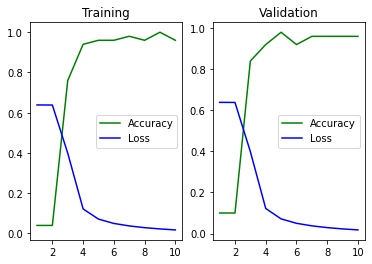

Count: 1, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 6502 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.06 - val acc:=0.08
# Epoch:=3/10  - train loss:=0.0280 - val loss:=0.0156, train acc:=0.58 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0109 - val loss:=0.0067, train acc:=0.80 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0055 - val loss:=0.0044, train acc:=0.90 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0037, train acc:=1.00 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0028 - val loss:=0.0033, train acc:=1.00 - val acc:=1.00
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0034, train acc:=0.96 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0031, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0028, train acc:=1.00 - val acc:=1.00

Total time tak

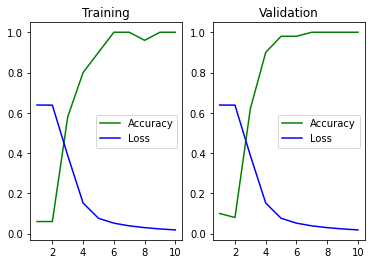

Count: 2, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 7635 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0339 - val loss:=0.0134, train acc:=0.72 - val acc:=0.80
# Epoch:=4/10  - train loss:=0.0096 - val loss:=0.0070, train acc:=0.92 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0054 - val loss:=0.0043, train acc:=0.98 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0032, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0026, train acc:=0.98 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0024, train acc:=1.00 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0024, train acc:=1.00 - val acc:=0.96
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0022, train acc:=1.00 - val acc:=1.00

Total time tak

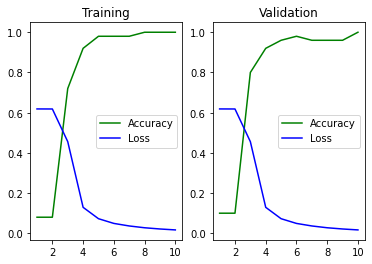

Count: 3, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 7774 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.06 - val acc:=0.12
# Epoch:=3/10  - train loss:=0.0306 - val loss:=0.0146, train acc:=0.80 - val acc:=0.70
# Epoch:=4/10  - train loss:=0.0102 - val loss:=0.0061, train acc:=0.88 - val acc:=0.98
# Epoch:=5/10  - train loss:=0.0053 - val loss:=0.0042, train acc:=0.96 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0035, train acc:=0.98 - val acc:=1.00
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0030, train acc:=0.98 - val acc:=1.00
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0029, train acc:=0.98 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0027, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0026, train acc:=1.00 - val acc:=0.96

Total time tak

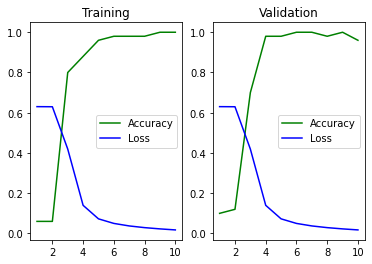

Count: 4, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 9459 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.04 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.06 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0301 - val loss:=0.0162, train acc:=0.72 - val acc:=0.66
# Epoch:=4/10  - train loss:=0.0098 - val loss:=0.0060, train acc:=0.90 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0051 - val loss:=0.0043, train acc:=0.98 - val acc:=0.94
# Epoch:=6/10  - train loss:=0.0035 - val loss:=0.0035, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0026 - val loss:=0.0029, train acc:=1.00 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0020 - val loss:=0.0026, train acc:=1.00 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0025, train acc:=0.98 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0012 - val loss:=0.0024, train acc:=0.98 - val acc:=1.00

Total time tak

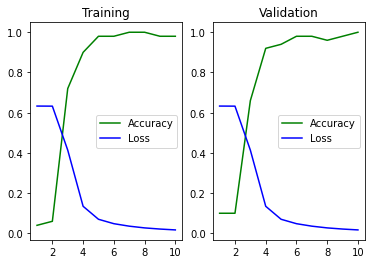

Count: 5, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 3258 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.16 - val acc:=0.14
# Epoch:=3/10  - train loss:=0.0309 - val loss:=0.0139, train acc:=0.76 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0094 - val loss:=0.0065, train acc:=0.90 - val acc:=0.94
# Epoch:=5/10  - train loss:=0.0052 - val loss:=0.0042, train acc:=0.98 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0033, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0029, train acc:=0.96 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0027, train acc:=1.00 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0026, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0026, train acc:=1.00 - val acc:=1.00

Total time tak

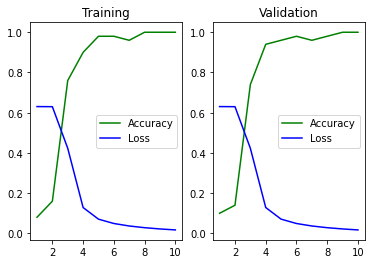

Count: 6, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 1517 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0459 - val loss:=0.0449, train acc:=0.20 - val acc:=0.14
# Epoch:=3/10  - train loss:=0.0250 - val loss:=0.0127, train acc:=0.72 - val acc:=0.68
# Epoch:=4/10  - train loss:=0.0085 - val loss:=0.0054, train acc:=0.98 - val acc:=0.96
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0039, train acc:=1.00 - val acc:=0.94
# Epoch:=6/10  - train loss:=0.0033 - val loss:=0.0030, train acc:=0.96 - val acc:=1.00
# Epoch:=7/10  - train loss:=0.0025 - val loss:=0.0028, train acc:=0.96 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0019 - val loss:=0.0025, train acc:=0.98 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0015 - val loss:=0.0025, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0012 - val loss:=0.0024, train acc:=1.00 - val acc:=1.00

Total time tak

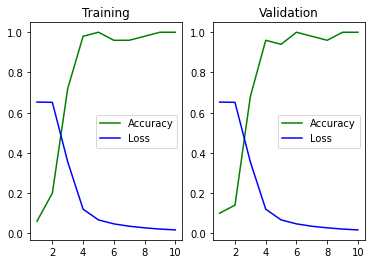

Count: 7, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 6197 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.06
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0454, train acc:=0.18 - val acc:=0.20
# Epoch:=3/10  - train loss:=0.0279 - val loss:=0.0130, train acc:=0.76 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0101 - val loss:=0.0066, train acc:=0.92 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0056 - val loss:=0.0045, train acc:=0.96 - val acc:=0.94
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0036, train acc:=1.00 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0029, train acc:=0.96 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0026, train acc:=1.00 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0025, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0026, train acc:=1.00 - val acc:=1.00

Total time tak

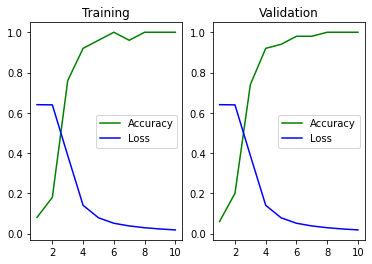

Count: 8, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 7682 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.04 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.06 - val acc:=0.08
# Epoch:=3/10  - train loss:=0.0333 - val loss:=0.0142, train acc:=0.66 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0093 - val loss:=0.0061, train acc:=0.90 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0052 - val loss:=0.0041, train acc:=0.98 - val acc:=0.94
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0032, train acc:=0.98 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0027, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0020 - val loss:=0.0026, train acc:=0.96 - val acc:=0.94
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0026, train acc:=0.98 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0025, train acc:=1.00 - val acc:=0.98

Total time tak

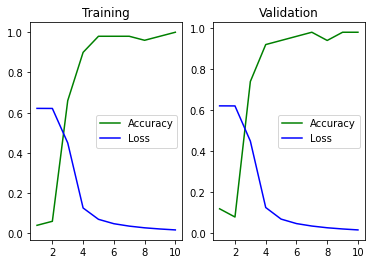

Count: 9, j=: 0


**************** Training model: mlp_on_gpu_default with seed: 6087 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.10 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0338 - val loss:=0.0179, train acc:=0.56 - val acc:=0.64
# Epoch:=4/10  - train loss:=0.0118 - val loss:=0.0070, train acc:=0.94 - val acc:=0.94
# Epoch:=5/10  - train loss:=0.0056 - val loss:=0.0046, train acc:=0.94 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0037, train acc:=0.96 - val acc:=1.00
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0030, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0026, train acc:=0.96 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0025, train acc:=0.96 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0025, train acc:=0.98 - val acc:=1.00

Total time tak

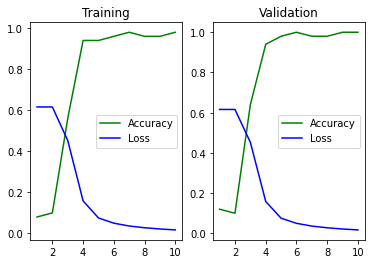

Count: 0, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 3773 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.04 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0289 - val loss:=0.0149, train acc:=0.74 - val acc:=0.64
# Epoch:=4/10  - train loss:=0.0098 - val loss:=0.0060, train acc:=0.90 - val acc:=0.96
# Epoch:=5/10  - train loss:=0.0051 - val loss:=0.0043, train acc:=0.98 - val acc:=1.00
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0036, train acc:=0.96 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0031, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0029, train acc:=0.98 - val acc:=0.94
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0026, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0025, train acc:=1.00 - val acc:=1.00

Total time taken

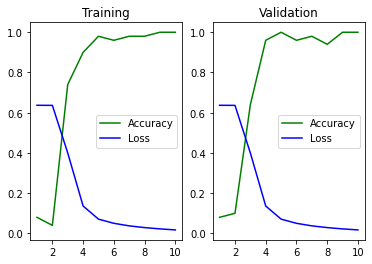

Count: 1, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 1871 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=3/10  - train loss:=0.0325 - val loss:=0.0175, train acc:=0.62 - val acc:=0.54
# Epoch:=4/10  - train loss:=0.0116 - val loss:=0.0073, train acc:=0.88 - val acc:=0.96
# Epoch:=5/10  - train loss:=0.0057 - val loss:=0.0044, train acc:=0.92 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0035, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0031, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0020 - val loss:=0.0028, train acc:=1.00 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0027, train acc:=0.98 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0024, train acc:=1.00 - val acc:=1.00

Total time taken

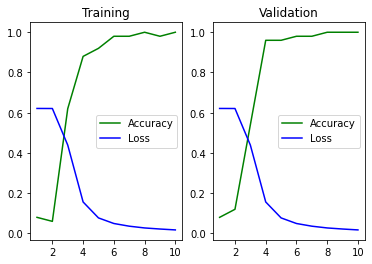

Count: 2, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 9604 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.14
# Epoch:=3/10  - train loss:=0.0342 - val loss:=0.0165, train acc:=0.64 - val acc:=0.52
# Epoch:=4/10  - train loss:=0.0110 - val loss:=0.0076, train acc:=0.90 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0059 - val loss:=0.0047, train acc:=0.96 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0040 - val loss:=0.0037, train acc:=0.94 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0029 - val loss:=0.0037, train acc:=0.98 - val acc:=1.00
# Epoch:=8/10  - train loss:=0.0022 - val loss:=0.0032, train acc:=0.98 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0031, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0012 - val loss:=0.0027, train acc:=1.00 - val acc:=1.00

Total time taken

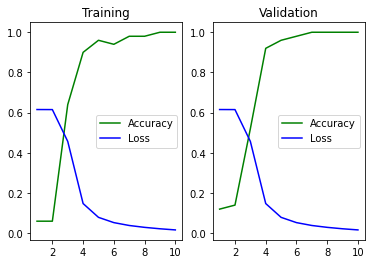

Count: 3, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 9044 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0457 - val loss:=0.0421, train acc:=0.20 - val acc:=0.16
# Epoch:=3/10  - train loss:=0.0252 - val loss:=0.0100, train acc:=0.80 - val acc:=0.80
# Epoch:=4/10  - train loss:=0.0076 - val loss:=0.0061, train acc:=0.90 - val acc:=0.96
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0042, train acc:=0.98 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0033 - val loss:=0.0033, train acc:=0.96 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0026 - val loss:=0.0029, train acc:=0.98 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0020 - val loss:=0.0033, train acc:=0.94 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0026, train acc:=0.96 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0025, train acc:=0.98 - val acc:=1.00

Total time taken

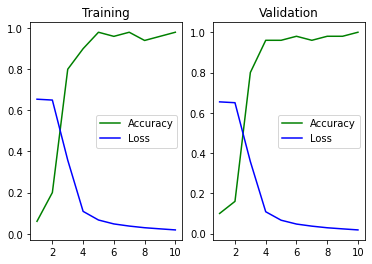

Count: 4, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 2834 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.12 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0348 - val loss:=0.0183, train acc:=0.58 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0130 - val loss:=0.0071, train acc:=0.92 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0060 - val loss:=0.0046, train acc:=0.92 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0038 - val loss:=0.0034, train acc:=1.00 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0028 - val loss:=0.0032, train acc:=1.00 - val acc:=1.00
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0027, train acc:=1.00 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0025, train acc:=0.96 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0025, train acc:=1.00 - val acc:=1.00

Total time taken

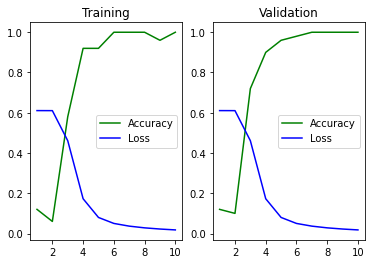

Count: 5, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 9960 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.10 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.10 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0339 - val loss:=0.0165, train acc:=0.68 - val acc:=0.64
# Epoch:=4/10  - train loss:=0.0114 - val loss:=0.0069, train acc:=0.94 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0058 - val loss:=0.0051, train acc:=0.96 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0041 - val loss:=0.0040, train acc:=1.00 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0031 - val loss:=0.0035, train acc:=1.00 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0024 - val loss:=0.0033, train acc:=0.96 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0019 - val loss:=0.0029, train acc:=0.96 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0015 - val loss:=0.0030, train acc:=0.98 - val acc:=0.96

Total time taken

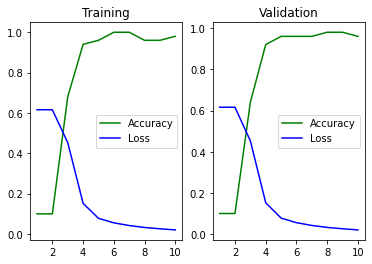

Count: 6, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 1919 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0455, train acc:=0.18 - val acc:=0.22
# Epoch:=3/10  - train loss:=0.0311 - val loss:=0.0151, train acc:=0.72 - val acc:=0.86
# Epoch:=4/10  - train loss:=0.0105 - val loss:=0.0065, train acc:=0.86 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0053 - val loss:=0.0043, train acc:=0.96 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0034, train acc:=0.96 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0028 - val loss:=0.0031, train acc:=1.00 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0022 - val loss:=0.0031, train acc:=0.98 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0027, train acc:=0.96 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0027, train acc:=0.98 - val acc:=1.00

Total time taken

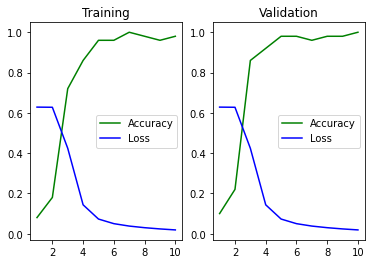

Count: 7, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 1825 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.04 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.02 - val acc:=0.08
# Epoch:=3/10  - train loss:=0.0345 - val loss:=0.0152, train acc:=0.68 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0102 - val loss:=0.0062, train acc:=0.96 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0053 - val loss:=0.0044, train acc:=0.90 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0033, train acc:=0.96 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0027, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0025, train acc:=0.96 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0024, train acc:=0.98 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0024, train acc:=1.00 - val acc:=1.00

Total time taken

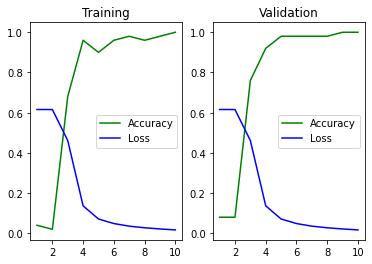

Count: 8, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 7686 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.10 - val acc:=0.08
# Epoch:=3/10  - train loss:=0.0292 - val loss:=0.0161, train acc:=0.60 - val acc:=0.60
# Epoch:=4/10  - train loss:=0.0103 - val loss:=0.0064, train acc:=0.88 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0052 - val loss:=0.0042, train acc:=0.98 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0035, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0031, train acc:=1.00 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0020 - val loss:=0.0029, train acc:=0.98 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0027, train acc:=0.98 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0026, train acc:=1.00 - val acc:=1.00

Total time taken

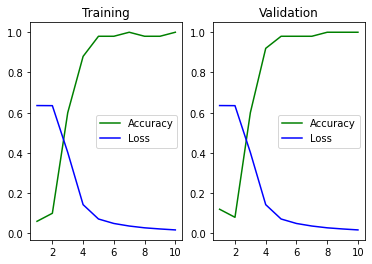

Count: 9, j=: 0


**************** Training model: mlp_on_gpu_RegL1 with seed: 5557 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0397 - val loss:=0.0221, train acc:=0.58 - val acc:=0.50
# Epoch:=4/10  - train loss:=0.0138 - val loss:=0.0075, train acc:=0.90 - val acc:=0.94
# Epoch:=5/10  - train loss:=0.0062 - val loss:=0.0049, train acc:=0.90 - val acc:=0.94
# Epoch:=6/10  - train loss:=0.0041 - val loss:=0.0035, train acc:=0.96 - val acc:=0.94
# Epoch:=7/10  - train loss:=0.0030 - val loss:=0.0031, train acc:=0.98 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0023 - val loss:=0.0030, train acc:=1.00 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0019 - val loss:=0.0028, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0015 - val loss:=0.0028, train acc:=1.00 - val acc:=1.00

Total time taken

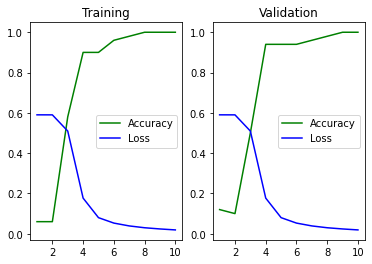

Count: 0, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 5711 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.10 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.04 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0423 - val loss:=0.0318, train acc:=0.38 - val acc:=0.30
# Epoch:=4/10  - train loss:=0.0203 - val loss:=0.0107, train acc:=0.80 - val acc:=0.84
# Epoch:=5/10  - train loss:=0.0077 - val loss:=0.0055, train acc:=1.00 - val acc:=0.90
# Epoch:=6/10  - train loss:=0.0047 - val loss:=0.0039, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0034 - val loss:=0.0032, train acc:=0.98 - val acc:=1.00
# Epoch:=8/10  - train loss:=0.0026 - val loss:=0.0028, train acc:=0.98 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0021 - val loss:=0.0028, train acc:=0.98 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0016 - val loss:=0.0025, train acc:=0.96 - val acc:=1.00

Total time taken

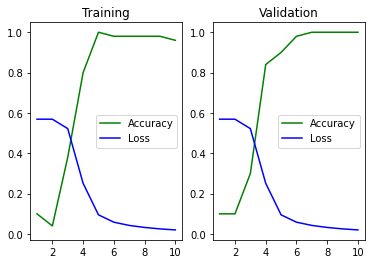

Count: 1, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 7603 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.14
# Epoch:=3/10  - train loss:=0.0373 - val loss:=0.0189, train acc:=0.64 - val acc:=0.64
# Epoch:=4/10  - train loss:=0.0129 - val loss:=0.0074, train acc:=0.82 - val acc:=0.98
# Epoch:=5/10  - train loss:=0.0063 - val loss:=0.0050, train acc:=0.92 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0043 - val loss:=0.0041, train acc:=1.00 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0032 - val loss:=0.0033, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0025 - val loss:=0.0029, train acc:=0.96 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0020 - val loss:=0.0028, train acc:=0.98 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0016 - val loss:=0.0028, train acc:=1.00 - val acc:=1.00

Total time taken

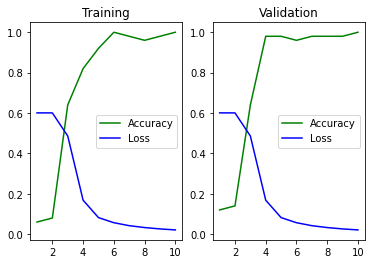

Count: 2, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 5512 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0459 - val loss:=0.0433, train acc:=0.22 - val acc:=0.18
# Epoch:=3/10  - train loss:=0.0274 - val loss:=0.0106, train acc:=0.88 - val acc:=0.82
# Epoch:=4/10  - train loss:=0.0083 - val loss:=0.0058, train acc:=0.94 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0050 - val loss:=0.0040, train acc:=1.00 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0034 - val loss:=0.0030, train acc:=0.98 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0026 - val loss:=0.0028, train acc:=0.98 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0026, train acc:=1.00 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0026, train acc:=1.00 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0025, train acc:=1.00 - val acc:=1.00

Total time taken

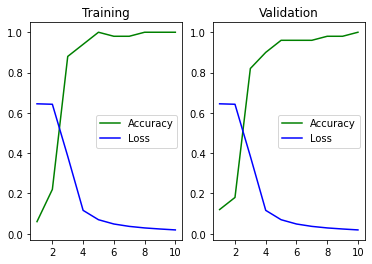

Count: 3, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 6421 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.02 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.04 - val acc:=0.08
# Epoch:=3/10  - train loss:=0.0273 - val loss:=0.0137, train acc:=0.64 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0101 - val loss:=0.0063, train acc:=0.98 - val acc:=0.88
# Epoch:=5/10  - train loss:=0.0056 - val loss:=0.0046, train acc:=0.96 - val acc:=0.94
# Epoch:=6/10  - train loss:=0.0040 - val loss:=0.0037, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0030 - val loss:=0.0032, train acc:=1.00 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0023 - val loss:=0.0030, train acc:=0.98 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0018 - val loss:=0.0027, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0015 - val loss:=0.0025, train acc:=1.00 - val acc:=0.98

Total time taken

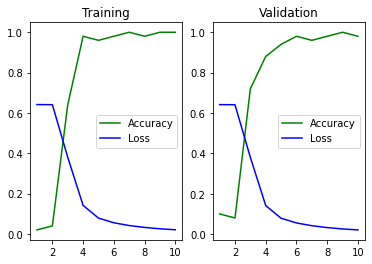

Count: 4, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 9283 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.04 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=3/10  - train loss:=0.0344 - val loss:=0.0165, train acc:=0.68 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0110 - val loss:=0.0066, train acc:=0.88 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0056 - val loss:=0.0044, train acc:=0.98 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0038 - val loss:=0.0034, train acc:=1.00 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0029 - val loss:=0.0029, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0022 - val loss:=0.0025, train acc:=0.98 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0018 - val loss:=0.0025, train acc:=1.00 - val acc:=0.94
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0024, train acc:=1.00 - val acc:=0.96

Total time taken

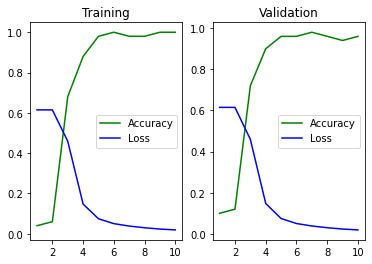

Count: 5, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 3209 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.10 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.04 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0306 - val loss:=0.0137, train acc:=0.74 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0090 - val loss:=0.0060, train acc:=0.92 - val acc:=0.96
# Epoch:=5/10  - train loss:=0.0052 - val loss:=0.0040, train acc:=0.94 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0031, train acc:=0.96 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0027, train acc:=1.00 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0024, train acc:=0.92 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0023, train acc:=0.98 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0022, train acc:=0.98 - val acc:=0.98

Total time taken

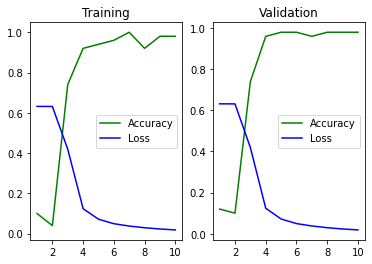

Count: 6, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 5064 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.08
# Epoch:=3/10  - train loss:=0.0360 - val loss:=0.0186, train acc:=0.52 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0121 - val loss:=0.0065, train acc:=0.88 - val acc:=0.88
# Epoch:=5/10  - train loss:=0.0054 - val loss:=0.0042, train acc:=0.94 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0033, train acc:=0.94 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0027, train acc:=0.96 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0022 - val loss:=0.0027, train acc:=0.98 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0024, train acc:=1.00 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0024, train acc:=1.00 - val acc:=0.98

Total time taken

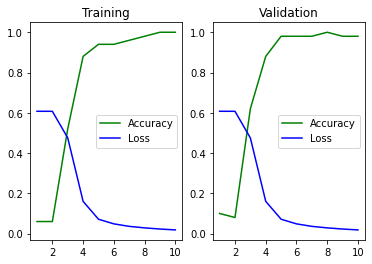

Count: 7, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 5354 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0371 - val loss:=0.0181, train acc:=0.54 - val acc:=0.64
# Epoch:=4/10  - train loss:=0.0121 - val loss:=0.0070, train acc:=0.92 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0061 - val loss:=0.0053, train acc:=0.98 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0041 - val loss:=0.0038, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0031 - val loss:=0.0032, train acc:=0.98 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0024 - val loss:=0.0028, train acc:=1.00 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0019 - val loss:=0.0030, train acc:=0.98 - val acc:=0.96
# Epoch:=10/10  - train loss:=0.0016 - val loss:=0.0025, train acc:=1.00 - val acc:=0.96

Total time taken

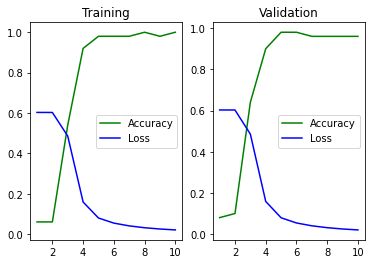

Count: 8, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 1392 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.06 - val acc:=0.14
# Epoch:=3/10  - train loss:=0.0334 - val loss:=0.0177, train acc:=0.48 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0103 - val loss:=0.0062, train acc:=0.88 - val acc:=0.88
# Epoch:=5/10  - train loss:=0.0053 - val loss:=0.0041, train acc:=0.96 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0036 - val loss:=0.0033, train acc:=1.00 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0028 - val loss:=0.0028, train acc:=0.96 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0026, train acc:=1.00 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0023, train acc:=1.00 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0023, train acc:=1.00 - val acc:=1.00

Total time taken

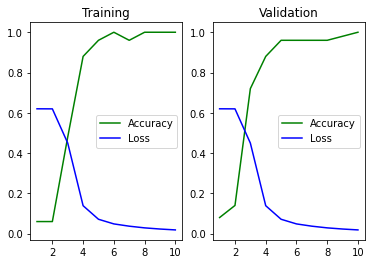

Count: 9, j=: 0


**************** Training model: mlp_on_gpu_RegL2 with seed: 8513 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.14
# Epoch:=3/10  - train loss:=0.0355 - val loss:=0.0175, train acc:=0.66 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0108 - val loss:=0.0065, train acc:=0.96 - val acc:=0.96
# Epoch:=5/10  - train loss:=0.0055 - val loss:=0.0042, train acc:=0.96 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0031, train acc:=0.96 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0027, train acc:=0.98 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0021 - val loss:=0.0025, train acc:=0.98 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0023, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0024, train acc:=1.00 - val acc:=0.98

Total time taken

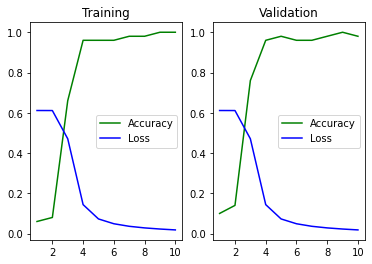

Count: 0, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 1357 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.08 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0341 - val loss:=0.0176, train acc:=0.70 - val acc:=0.66
# Epoch:=4/10  - train loss:=0.0117 - val loss:=0.0075, train acc:=0.92 - val acc:=0.94
# Epoch:=5/10  - train loss:=0.0059 - val loss:=0.0046, train acc:=0.98 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0038 - val loss:=0.0036, train acc:=1.00 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0027 - val loss:=0.0031, train acc:=1.00 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0020 - val loss:=0.0025, train acc:=0.98 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0016 - val loss:=0.0025, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0013 - val loss:=0.0023, train acc:=0.98 - val acc:=1.00

Total time tak

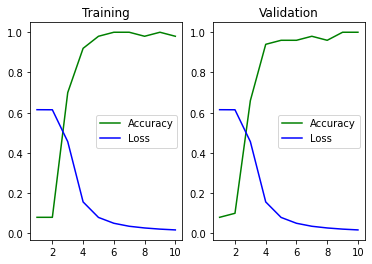

Count: 1, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 4993 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.08 - val acc:=0.14
# Epoch:=3/10  - train loss:=0.0324 - val loss:=0.0148, train acc:=0.68 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0094 - val loss:=0.0064, train acc:=0.90 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0053 - val loss:=0.0045, train acc:=0.98 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0036, train acc:=0.96 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0029 - val loss:=0.0032, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0023 - val loss:=0.0028, train acc:=0.94 - val acc:=0.96
# Epoch:=9/10  - train loss:=0.0019 - val loss:=0.0028, train acc:=0.98 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0016 - val loss:=0.0028, train acc:=0.98 - val acc:=1.00

Total time tak

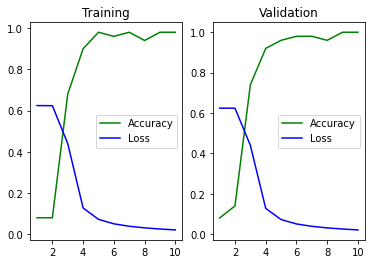

Count: 2, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 7597 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.14 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.12
# Epoch:=3/10  - train loss:=0.0377 - val loss:=0.0196, train acc:=0.58 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0115 - val loss:=0.0066, train acc:=0.84 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0057 - val loss:=0.0047, train acc:=0.96 - val acc:=0.92
# Epoch:=6/10  - train loss:=0.0039 - val loss:=0.0037, train acc:=0.98 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0030 - val loss:=0.0032, train acc:=1.00 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0023 - val loss:=0.0026, train acc:=0.98 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0018 - val loss:=0.0026, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0015 - val loss:=0.0025, train acc:=0.98 - val acc:=0.96

Total time tak

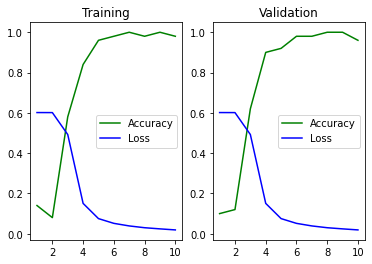

Count: 3, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 2802 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.10 - val acc:=0.06
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0405 - val loss:=0.0224, train acc:=0.48 - val acc:=0.60
# Epoch:=4/10  - train loss:=0.0138 - val loss:=0.0076, train acc:=0.84 - val acc:=0.88
# Epoch:=5/10  - train loss:=0.0064 - val loss:=0.0049, train acc:=0.92 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0043 - val loss:=0.0038, train acc:=0.96 - val acc:=0.98
# Epoch:=7/10  - train loss:=0.0032 - val loss:=0.0031, train acc:=0.92 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0025 - val loss:=0.0027, train acc:=0.94 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0020 - val loss:=0.0026, train acc:=1.00 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0017 - val loss:=0.0025, train acc:=0.98 - val acc:=0.96

Total time tak

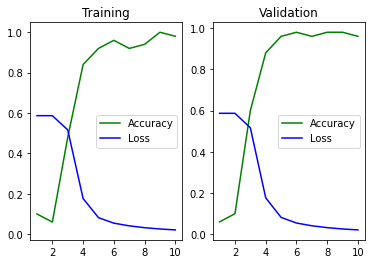

Count: 4, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 3216 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0390 - val loss:=0.0206, train acc:=0.42 - val acc:=0.60
# Epoch:=4/10  - train loss:=0.0135 - val loss:=0.0071, train acc:=0.92 - val acc:=0.96
# Epoch:=5/10  - train loss:=0.0059 - val loss:=0.0047, train acc:=0.96 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0039 - val loss:=0.0035, train acc:=0.98 - val acc:=1.00
# Epoch:=7/10  - train loss:=0.0029 - val loss:=0.0031, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0023 - val loss:=0.0026, train acc:=1.00 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0018 - val loss:=0.0025, train acc:=1.00 - val acc:=0.96
# Epoch:=10/10  - train loss:=0.0015 - val loss:=0.0023, train acc:=1.00 - val acc:=1.00

Total time tak

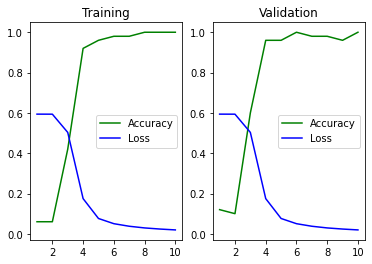

Count: 5, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 9016 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.12 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0375 - val loss:=0.0200, train acc:=0.50 - val acc:=0.78
# Epoch:=4/10  - train loss:=0.0139 - val loss:=0.0085, train acc:=0.84 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0064 - val loss:=0.0050, train acc:=0.94 - val acc:=0.96
# Epoch:=6/10  - train loss:=0.0042 - val loss:=0.0038, train acc:=0.98 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0030 - val loss:=0.0031, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0023 - val loss:=0.0027, train acc:=0.98 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0018 - val loss:=0.0025, train acc:=0.96 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0015 - val loss:=0.0024, train acc:=1.00 - val acc:=0.98

Total time tak

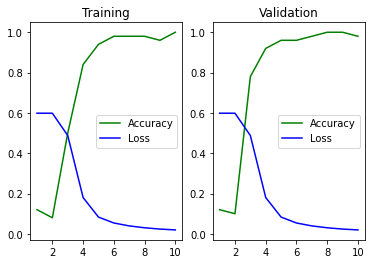

Count: 6, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 2757 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.12 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.02 - val acc:=0.16
# Epoch:=3/10  - train loss:=0.0439 - val loss:=0.0295, train acc:=0.42 - val acc:=0.52
# Epoch:=4/10  - train loss:=0.0176 - val loss:=0.0100, train acc:=0.86 - val acc:=0.88
# Epoch:=5/10  - train loss:=0.0074 - val loss:=0.0055, train acc:=0.92 - val acc:=1.00
# Epoch:=6/10  - train loss:=0.0047 - val loss:=0.0043, train acc:=0.96 - val acc:=0.88
# Epoch:=7/10  - train loss:=0.0034 - val loss:=0.0033, train acc:=0.96 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0025 - val loss:=0.0029, train acc:=1.00 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0020 - val loss:=0.0024, train acc:=0.96 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0016 - val loss:=0.0024, train acc:=1.00 - val acc:=1.00

Total time tak

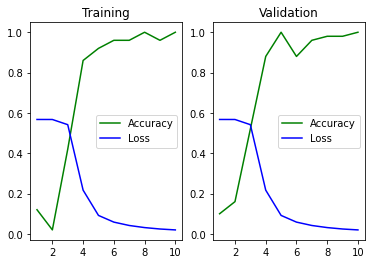

Count: 7, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 3795 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.04 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0457, train acc:=0.12 - val acc:=0.16
# Epoch:=3/10  - train loss:=0.0290 - val loss:=0.0150, train acc:=0.74 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0099 - val loss:=0.0065, train acc:=0.90 - val acc:=0.96
# Epoch:=5/10  - train loss:=0.0054 - val loss:=0.0046, train acc:=0.92 - val acc:=0.98
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0036, train acc:=1.00 - val acc:=1.00
# Epoch:=7/10  - train loss:=0.0028 - val loss:=0.0033, train acc:=0.98 - val acc:=1.00
# Epoch:=8/10  - train loss:=0.0022 - val loss:=0.0031, train acc:=1.00 - val acc:=1.00
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0026, train acc:=1.00 - val acc:=0.98
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0026, train acc:=0.98 - val acc:=1.00

Total time tak

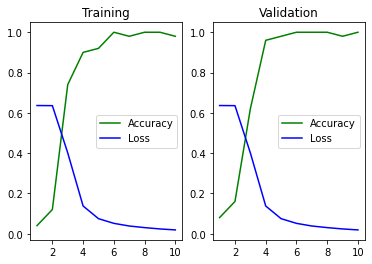

Count: 8, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 9972 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.08
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.10
# Epoch:=3/10  - train loss:=0.0378 - val loss:=0.0199, train acc:=0.54 - val acc:=0.54
# Epoch:=4/10  - train loss:=0.0129 - val loss:=0.0073, train acc:=0.90 - val acc:=0.88
# Epoch:=5/10  - train loss:=0.0059 - val loss:=0.0046, train acc:=1.00 - val acc:=0.94
# Epoch:=6/10  - train loss:=0.0040 - val loss:=0.0037, train acc:=1.00 - val acc:=0.92
# Epoch:=7/10  - train loss:=0.0030 - val loss:=0.0031, train acc:=0.98 - val acc:=0.98
# Epoch:=8/10  - train loss:=0.0023 - val loss:=0.0027, train acc:=0.98 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0019 - val loss:=0.0028, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0015 - val loss:=0.0024, train acc:=1.00 - val acc:=1.00

Total time tak

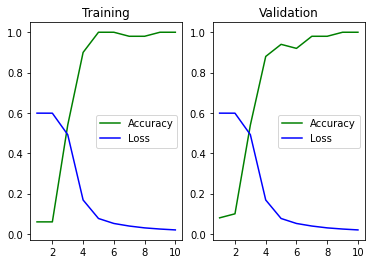

Count: 9, j=: 0


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 4616 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0460 - val loss:=0.0457, train acc:=0.14 - val acc:=0.16
# Epoch:=3/10  - train loss:=0.0317 - val loss:=0.0199, train acc:=0.68 - val acc:=0.60
# Epoch:=4/10  - train loss:=0.0114 - val loss:=0.0060, train acc:=0.92 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0053 - val loss:=0.0042, train acc:=1.00 - val acc:=0.94
# Epoch:=6/10  - train loss:=0.0037 - val loss:=0.0034, train acc:=1.00 - val acc:=0.96
# Epoch:=7/10  - train loss:=0.0028 - val loss:=0.0028, train acc:=0.98 - val acc:=0.96
# Epoch:=8/10  - train loss:=0.0022 - val loss:=0.0026, train acc:=1.00 - val acc:=0.98
# Epoch:=9/10  - train loss:=0.0017 - val loss:=0.0025, train acc:=1.00 - val acc:=1.00
# Epoch:=10/10  - train loss:=0.0014 - val loss:=0.0024, train acc:=1.00 - val acc:=1.00

Total time tak

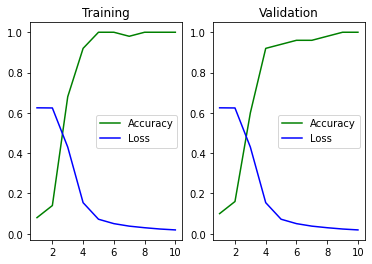

Data Split: 
X_train: (50000, 784), y_train: (50000, 10)
X_test : (10000, 784), y_test : (10000, 10)
X_val  : (10000, 784), y_val  : (10000, 10)
Count: 0, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 3872 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0450, train acc:=0.46 - val acc:=0.28
# Epoch:=2/10  - train loss:=0.0252 - val loss:=0.0195, train acc:=0.58 - val acc:=0.60
# Epoch:=3/10  - train loss:=0.0160 - val loss:=0.0138, train acc:=0.64 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0121 - val loss:=0.0112, train acc:=0.76 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0102 - val loss:=0.0107, train acc:=0.70 - val acc:=0.74
# Epoch:=6/10  - train loss:=0.0090 - val loss:=0.0097, train acc:=0.78 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0081 - val loss:=0.0085, train acc:=0.70 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0075 - val loss:=0.0079, train acc:=0.82 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0071 - val loss:

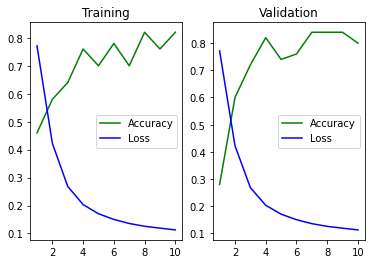

Count: 1, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 4432 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0455, train acc:=0.20 - val acc:=0.20
# Epoch:=2/10  - train loss:=0.0262 - val loss:=0.0192, train acc:=0.56 - val acc:=0.58
# Epoch:=3/10  - train loss:=0.0156 - val loss:=0.0131, train acc:=0.70 - val acc:=0.78
# Epoch:=4/10  - train loss:=0.0122 - val loss:=0.0173, train acc:=0.72 - val acc:=0.74
# Epoch:=5/10  - train loss:=0.0101 - val loss:=0.0096, train acc:=0.82 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0089 - val loss:=0.0089, train acc:=0.76 - val acc:=0.82
# Epoch:=7/10  - train loss:=0.0081 - val loss:=0.0083, train acc:=0.80 - val acc:=0.92
# Epoch:=8/10  - train loss:=0.0076 - val loss:=0.0079, train acc:=0.76 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0071 - val loss:=0.0076, train acc:=0.82 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0067 - val loss:=0.0077, train acc:=0.74 - val acc:=0.84

Total time tak

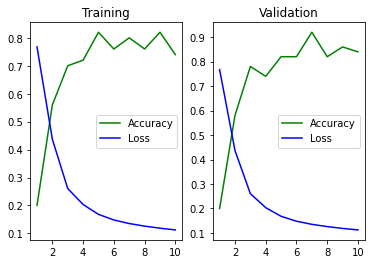

Count: 2, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 5618 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0455, train acc:=0.24 - val acc:=0.20
# Epoch:=2/10  - train loss:=0.0269 - val loss:=0.0224, train acc:=0.44 - val acc:=0.50
# Epoch:=3/10  - train loss:=0.0163 - val loss:=0.0130, train acc:=0.70 - val acc:=0.82
# Epoch:=4/10  - train loss:=0.0118 - val loss:=0.0107, train acc:=0.76 - val acc:=0.80
# Epoch:=5/10  - train loss:=0.0097 - val loss:=0.0092, train acc:=0.72 - val acc:=0.84
# Epoch:=6/10  - train loss:=0.0087 - val loss:=0.0091, train acc:=0.82 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0080 - val loss:=0.0081, train acc:=0.80 - val acc:=0.88
# Epoch:=8/10  - train loss:=0.0075 - val loss:=0.0087, train acc:=0.80 - val acc:=0.88
# Epoch:=9/10  - train loss:=0.0071 - val loss:=0.0078, train acc:=0.84 - val acc:=0.88
# Epoch:=10/10  - train loss:=0.0068 - val loss:=0.0075, train acc:=0.76 - val acc:=0.90

Total time tak

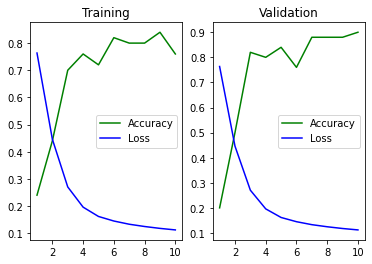

Count: 3, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 1367 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.14 - val acc:=0.18
# Epoch:=2/10  - train loss:=0.0283 - val loss:=0.0195, train acc:=0.58 - val acc:=0.46
# Epoch:=3/10  - train loss:=0.0178 - val loss:=0.0145, train acc:=0.70 - val acc:=0.70
# Epoch:=4/10  - train loss:=0.0127 - val loss:=0.0113, train acc:=0.76 - val acc:=0.74
# Epoch:=5/10  - train loss:=0.0104 - val loss:=0.0109, train acc:=0.72 - val acc:=0.78
# Epoch:=6/10  - train loss:=0.0091 - val loss:=0.0088, train acc:=0.78 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0083, train acc:=0.72 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0076 - val loss:=0.0077, train acc:=0.80 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0071 - val loss:=0.0076, train acc:=0.82 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0067 - val loss:=0.0078, train acc:=0.84 - val acc:=0.82

Total time tak

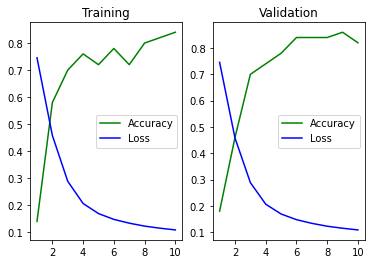

Count: 4, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 8004 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.30 - val acc:=0.18
# Epoch:=2/10  - train loss:=0.0266 - val loss:=0.0187, train acc:=0.58 - val acc:=0.44
# Epoch:=3/10  - train loss:=0.0155 - val loss:=0.0144, train acc:=0.68 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0121 - val loss:=0.0113, train acc:=0.74 - val acc:=0.74
# Epoch:=5/10  - train loss:=0.0100 - val loss:=0.0132, train acc:=0.70 - val acc:=0.64
# Epoch:=6/10  - train loss:=0.0088 - val loss:=0.0085, train acc:=0.82 - val acc:=0.86
# Epoch:=7/10  - train loss:=0.0081 - val loss:=0.0088, train acc:=0.76 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0075 - val loss:=0.0087, train acc:=0.78 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0070 - val loss:=0.0075, train acc:=0.76 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0067 - val loss:=0.0074, train acc:=0.76 - val acc:=0.90

Total time tak

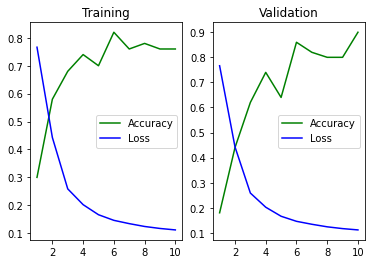

Count: 5, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 8435 ****************

# Epoch:=1/10  - train loss:=0.0457 - val loss:=0.0390, train acc:=0.24 - val acc:=0.14
# Epoch:=2/10  - train loss:=0.0244 - val loss:=0.0182, train acc:=0.74 - val acc:=0.60
# Epoch:=3/10  - train loss:=0.0163 - val loss:=0.0133, train acc:=0.64 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0120 - val loss:=0.0120, train acc:=0.70 - val acc:=0.78
# Epoch:=5/10  - train loss:=0.0098 - val loss:=0.0101, train acc:=0.74 - val acc:=0.80
# Epoch:=6/10  - train loss:=0.0088 - val loss:=0.0094, train acc:=0.72 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0081 - val loss:=0.0084, train acc:=0.86 - val acc:=0.78
# Epoch:=8/10  - train loss:=0.0075 - val loss:=0.0089, train acc:=0.82 - val acc:=0.78
# Epoch:=9/10  - train loss:=0.0071 - val loss:=0.0079, train acc:=0.80 - val acc:=0.82
# Epoch:=10/10  - train loss:=0.0067 - val loss:=0.0084, train acc:=0.76 - val acc:=0.78

Total time tak

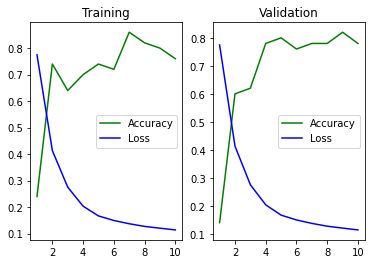

Count: 6, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 8374 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.22 - val acc:=0.20
# Epoch:=2/10  - train loss:=0.0272 - val loss:=0.0192, train acc:=0.52 - val acc:=0.58
# Epoch:=3/10  - train loss:=0.0160 - val loss:=0.0135, train acc:=0.74 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0122 - val loss:=0.0117, train acc:=0.76 - val acc:=0.80
# Epoch:=5/10  - train loss:=0.0101 - val loss:=0.0097, train acc:=0.70 - val acc:=0.86
# Epoch:=6/10  - train loss:=0.0089 - val loss:=0.0087, train acc:=0.74 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0080 - val loss:=0.0080, train acc:=0.74 - val acc:=0.86
# Epoch:=8/10  - train loss:=0.0075 - val loss:=0.0078, train acc:=0.78 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0071 - val loss:=0.0074, train acc:=0.76 - val acc:=0.84
# Epoch:=10/10  - train loss:=0.0067 - val loss:=0.0072, train acc:=0.84 - val acc:=0.88

Total time tak

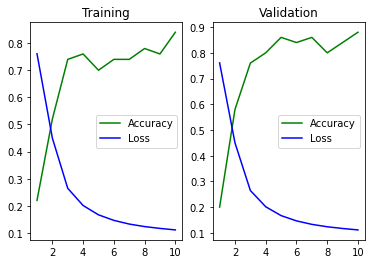

Count: 7, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 5208 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0457, train acc:=0.20 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0268 - val loss:=0.0241, train acc:=0.56 - val acc:=0.48
# Epoch:=3/10  - train loss:=0.0157 - val loss:=0.0131, train acc:=0.68 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0121 - val loss:=0.0107, train acc:=0.76 - val acc:=0.86
# Epoch:=5/10  - train loss:=0.0100 - val loss:=0.0098, train acc:=0.76 - val acc:=0.74
# Epoch:=6/10  - train loss:=0.0089 - val loss:=0.0087, train acc:=0.72 - val acc:=0.78
# Epoch:=7/10  - train loss:=0.0082 - val loss:=0.0082, train acc:=0.76 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0076 - val loss:=0.0083, train acc:=0.82 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0072 - val loss:=0.0075, train acc:=0.78 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0068 - val loss:=0.0079, train acc:=0.84 - val acc:=0.90

Total time tak

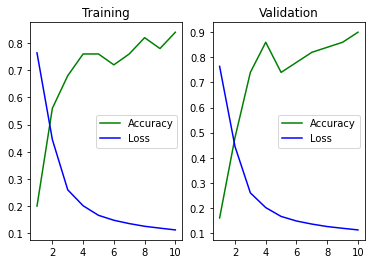

Count: 8, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 9663 ****************

# Epoch:=1/10  - train loss:=0.0459 - val loss:=0.0431, train acc:=0.20 - val acc:=0.24
# Epoch:=2/10  - train loss:=0.0264 - val loss:=0.0188, train acc:=0.56 - val acc:=0.50
# Epoch:=3/10  - train loss:=0.0158 - val loss:=0.0130, train acc:=0.68 - val acc:=0.78
# Epoch:=4/10  - train loss:=0.0123 - val loss:=0.0108, train acc:=0.76 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0101 - val loss:=0.0097, train acc:=0.74 - val acc:=0.86
# Epoch:=6/10  - train loss:=0.0089 - val loss:=0.0089, train acc:=0.80 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0080 - val loss:=0.0079, train acc:=0.76 - val acc:=0.88
# Epoch:=8/10  - train loss:=0.0074 - val loss:=0.0077, train acc:=0.82 - val acc:=0.90
# Epoch:=9/10  - train loss:=0.0070 - val loss:=0.0077, train acc:=0.84 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0067 - val loss:=0.0073, train acc:=0.78 - val acc:=0.88

Total time tak

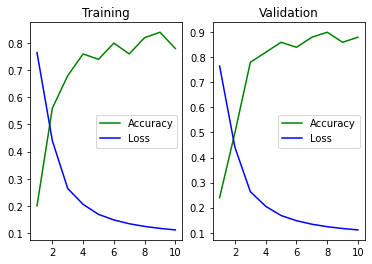

Count: 9, j=: 1


**************** Training model: mlp_on_gpu_default with seed: 2787 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.26 - val acc:=0.18
# Epoch:=2/10  - train loss:=0.0272 - val loss:=0.0185, train acc:=0.56 - val acc:=0.60
# Epoch:=3/10  - train loss:=0.0159 - val loss:=0.0138, train acc:=0.66 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0120 - val loss:=0.0104, train acc:=0.72 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0099 - val loss:=0.0093, train acc:=0.78 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0088 - val loss:=0.0088, train acc:=0.74 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0080 - val loss:=0.0082, train acc:=0.80 - val acc:=0.78
# Epoch:=8/10  - train loss:=0.0075 - val loss:=0.0080, train acc:=0.82 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0071 - val loss:=0.0081, train acc:=0.82 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0067 - val loss:=0.0080, train acc:=0.80 - val acc:=0.86

Total time tak

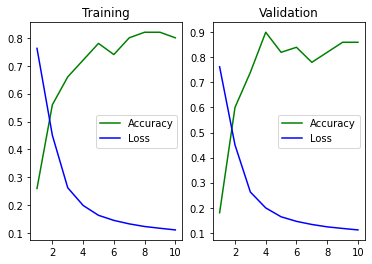

Count: 0, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 4506 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.18 - val acc:=0.18
# Epoch:=2/10  - train loss:=0.0283 - val loss:=0.0200, train acc:=0.60 - val acc:=0.54
# Epoch:=3/10  - train loss:=0.0162 - val loss:=0.0134, train acc:=0.74 - val acc:=0.72
# Epoch:=4/10  - train loss:=0.0124 - val loss:=0.0111, train acc:=0.78 - val acc:=0.78
# Epoch:=5/10  - train loss:=0.0104 - val loss:=0.0101, train acc:=0.76 - val acc:=0.80
# Epoch:=6/10  - train loss:=0.0092 - val loss:=0.0088, train acc:=0.82 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0084 - val loss:=0.0084, train acc:=0.78 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0080, train acc:=0.80 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0074 - val loss:=0.0082, train acc:=0.70 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0070 - val loss:=0.0076, train acc:=0.80 - val acc:=0.88

Total time taken

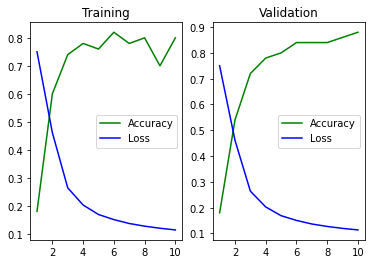

Count: 1, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 2546 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.12 - val acc:=0.18
# Epoch:=2/10  - train loss:=0.0280 - val loss:=0.0197, train acc:=0.50 - val acc:=0.58
# Epoch:=3/10  - train loss:=0.0170 - val loss:=0.0138, train acc:=0.76 - val acc:=0.66
# Epoch:=4/10  - train loss:=0.0126 - val loss:=0.0109, train acc:=0.76 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0103 - val loss:=0.0113, train acc:=0.74 - val acc:=0.76
# Epoch:=6/10  - train loss:=0.0090 - val loss:=0.0087, train acc:=0.74 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0082 - val loss:=0.0084, train acc:=0.74 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0076 - val loss:=0.0080, train acc:=0.76 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0072 - val loss:=0.0077, train acc:=0.82 - val acc:=0.76
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0074, train acc:=0.82 - val acc:=0.86

Total time taken

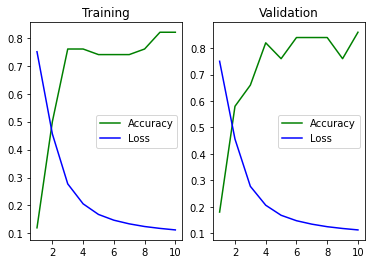

Count: 2, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 8698 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.16 - val acc:=0.18
# Epoch:=2/10  - train loss:=0.0303 - val loss:=0.0195, train acc:=0.64 - val acc:=0.52
# Epoch:=3/10  - train loss:=0.0173 - val loss:=0.0156, train acc:=0.64 - val acc:=0.82
# Epoch:=4/10  - train loss:=0.0127 - val loss:=0.0117, train acc:=0.80 - val acc:=0.78
# Epoch:=5/10  - train loss:=0.0103 - val loss:=0.0104, train acc:=0.72 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0091 - val loss:=0.0088, train acc:=0.78 - val acc:=0.86
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0082, train acc:=0.68 - val acc:=0.90
# Epoch:=8/10  - train loss:=0.0077 - val loss:=0.0085, train acc:=0.84 - val acc:=0.78
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0081, train acc:=0.76 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0075, train acc:=0.82 - val acc:=0.82

Total time taken

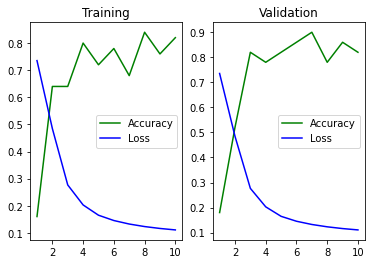

Count: 3, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 3288 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.10 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0312 - val loss:=0.0197, train acc:=0.52 - val acc:=0.58
# Epoch:=3/10  - train loss:=0.0161 - val loss:=0.0151, train acc:=0.68 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0123 - val loss:=0.0115, train acc:=0.70 - val acc:=0.84
# Epoch:=5/10  - train loss:=0.0100 - val loss:=0.0093, train acc:=0.74 - val acc:=0.84
# Epoch:=6/10  - train loss:=0.0089 - val loss:=0.0086, train acc:=0.78 - val acc:=0.88
# Epoch:=7/10  - train loss:=0.0082 - val loss:=0.0086, train acc:=0.78 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0076 - val loss:=0.0082, train acc:=0.84 - val acc:=0.76
# Epoch:=9/10  - train loss:=0.0072 - val loss:=0.0079, train acc:=0.82 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0074, train acc:=0.88 - val acc:=0.84

Total time taken

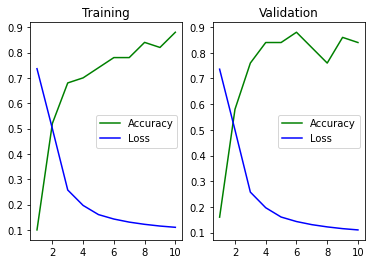

Count: 4, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 9760 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.10 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0301 - val loss:=0.0214, train acc:=0.56 - val acc:=0.56
# Epoch:=3/10  - train loss:=0.0180 - val loss:=0.0158, train acc:=0.66 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0128 - val loss:=0.0116, train acc:=0.78 - val acc:=0.78
# Epoch:=5/10  - train loss:=0.0104 - val loss:=0.0098, train acc:=0.70 - val acc:=0.78
# Epoch:=6/10  - train loss:=0.0091 - val loss:=0.0093, train acc:=0.82 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0088, train acc:=0.78 - val acc:=0.78
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0084, train acc:=0.82 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0077, train acc:=0.80 - val acc:=0.82
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0077, train acc:=0.86 - val acc:=0.82

Total time taken

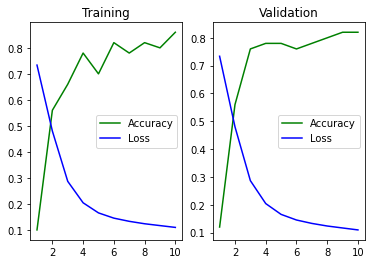

Count: 5, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 3940 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.06 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0305 - val loss:=0.0203, train acc:=0.60 - val acc:=0.54
# Epoch:=3/10  - train loss:=0.0170 - val loss:=0.0140, train acc:=0.72 - val acc:=0.78
# Epoch:=4/10  - train loss:=0.0125 - val loss:=0.0106, train acc:=0.78 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0101 - val loss:=0.0097, train acc:=0.72 - val acc:=0.80
# Epoch:=6/10  - train loss:=0.0089 - val loss:=0.0088, train acc:=0.80 - val acc:=0.80
# Epoch:=7/10  - train loss:=0.0082 - val loss:=0.0087, train acc:=0.72 - val acc:=0.80
# Epoch:=8/10  - train loss:=0.0077 - val loss:=0.0081, train acc:=0.80 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0078, train acc:=0.76 - val acc:=0.88
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0074, train acc:=0.86 - val acc:=0.86

Total time taken

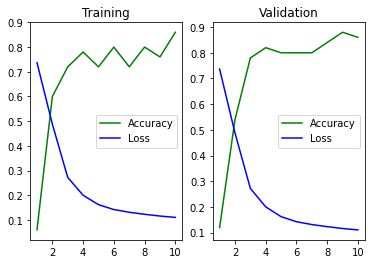

Count: 6, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 6490 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0457, train acc:=0.28 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0267 - val loss:=0.0211, train acc:=0.50 - val acc:=0.52
# Epoch:=3/10  - train loss:=0.0159 - val loss:=0.0140, train acc:=0.60 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0123 - val loss:=0.0109, train acc:=0.76 - val acc:=0.86
# Epoch:=5/10  - train loss:=0.0102 - val loss:=0.0098, train acc:=0.74 - val acc:=0.84
# Epoch:=6/10  - train loss:=0.0091 - val loss:=0.0093, train acc:=0.80 - val acc:=0.82
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0092, train acc:=0.78 - val acc:=0.76
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0085, train acc:=0.76 - val acc:=0.76
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0081, train acc:=0.82 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0077, train acc:=0.80 - val acc:=0.84

Total time taken

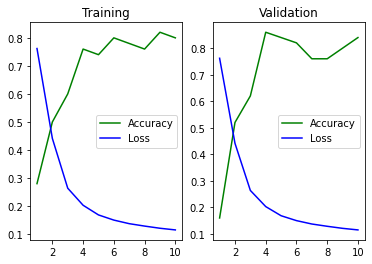

Count: 7, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 7943 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0450, train acc:=0.18 - val acc:=0.20
# Epoch:=2/10  - train loss:=0.0272 - val loss:=0.0216, train acc:=0.46 - val acc:=0.42
# Epoch:=3/10  - train loss:=0.0173 - val loss:=0.0145, train acc:=0.68 - val acc:=0.70
# Epoch:=4/10  - train loss:=0.0123 - val loss:=0.0110, train acc:=0.76 - val acc:=0.80
# Epoch:=5/10  - train loss:=0.0101 - val loss:=0.0098, train acc:=0.74 - val acc:=0.78
# Epoch:=6/10  - train loss:=0.0090 - val loss:=0.0091, train acc:=0.80 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0093, train acc:=0.74 - val acc:=0.78
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0080, train acc:=0.86 - val acc:=0.88
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0079, train acc:=0.86 - val acc:=0.84
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0076, train acc:=0.76 - val acc:=0.84

Total time taken

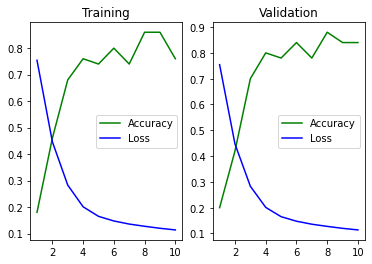

Count: 8, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 7545 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0457, train acc:=0.22 - val acc:=0.18
# Epoch:=2/10  - train loss:=0.0272 - val loss:=0.0195, train acc:=0.66 - val acc:=0.54
# Epoch:=3/10  - train loss:=0.0168 - val loss:=0.0134, train acc:=0.74 - val acc:=0.84
# Epoch:=4/10  - train loss:=0.0125 - val loss:=0.0111, train acc:=0.74 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0102 - val loss:=0.0105, train acc:=0.68 - val acc:=0.84
# Epoch:=6/10  - train loss:=0.0090 - val loss:=0.0086, train acc:=0.76 - val acc:=0.82
# Epoch:=7/10  - train loss:=0.0081 - val loss:=0.0081, train acc:=0.78 - val acc:=0.86
# Epoch:=8/10  - train loss:=0.0076 - val loss:=0.0078, train acc:=0.70 - val acc:=0.88
# Epoch:=9/10  - train loss:=0.0071 - val loss:=0.0074, train acc:=0.80 - val acc:=0.88
# Epoch:=10/10  - train loss:=0.0068 - val loss:=0.0075, train acc:=0.78 - val acc:=0.80

Total time taken

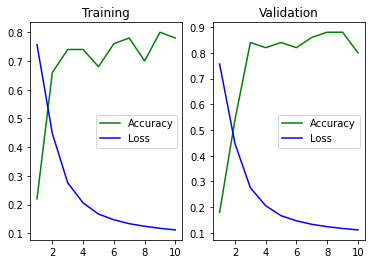

Count: 9, j=: 1


**************** Training model: mlp_on_gpu_RegL1 with seed: 8991 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.14 - val acc:=0.20
# Epoch:=2/10  - train loss:=0.0290 - val loss:=0.0189, train acc:=0.64 - val acc:=0.50
# Epoch:=3/10  - train loss:=0.0155 - val loss:=0.0137, train acc:=0.68 - val acc:=0.70
# Epoch:=4/10  - train loss:=0.0122 - val loss:=0.0118, train acc:=0.72 - val acc:=0.76
# Epoch:=5/10  - train loss:=0.0103 - val loss:=0.0098, train acc:=0.74 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0091 - val loss:=0.0087, train acc:=0.80 - val acc:=0.86
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0086, train acc:=0.76 - val acc:=0.78
# Epoch:=8/10  - train loss:=0.0077 - val loss:=0.0083, train acc:=0.84 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0078, train acc:=0.82 - val acc:=0.84
# Epoch:=10/10  - train loss:=0.0068 - val loss:=0.0075, train acc:=0.80 - val acc:=0.90

Total time taken

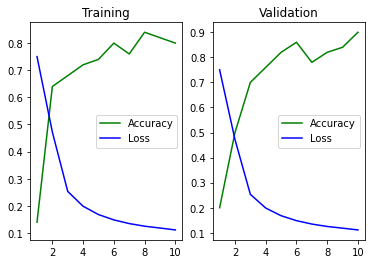

Count: 0, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 6010 ****************

# Epoch:=1/10  - train loss:=0.0461 - val loss:=0.0460, train acc:=0.10 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0346 - val loss:=0.0220, train acc:=0.52 - val acc:=0.48
# Epoch:=3/10  - train loss:=0.0172 - val loss:=0.0141, train acc:=0.68 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0129 - val loss:=0.0112, train acc:=0.70 - val acc:=0.86
# Epoch:=5/10  - train loss:=0.0105 - val loss:=0.0100, train acc:=0.78 - val acc:=0.76
# Epoch:=6/10  - train loss:=0.0092 - val loss:=0.0087, train acc:=0.82 - val acc:=0.80
# Epoch:=7/10  - train loss:=0.0084 - val loss:=0.0086, train acc:=0.82 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0080, train acc:=0.78 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0074 - val loss:=0.0076, train acc:=0.80 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0070 - val loss:=0.0075, train acc:=0.78 - val acc:=0.80

Total time taken

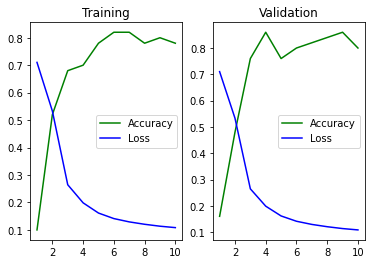

Count: 1, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 7437 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0452, train acc:=0.22 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0281 - val loss:=0.0202, train acc:=0.58 - val acc:=0.52
# Epoch:=3/10  - train loss:=0.0173 - val loss:=0.0136, train acc:=0.62 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0126 - val loss:=0.0112, train acc:=0.78 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0103 - val loss:=0.0095, train acc:=0.80 - val acc:=0.74
# Epoch:=6/10  - train loss:=0.0091 - val loss:=0.0091, train acc:=0.76 - val acc:=0.86
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0090, train acc:=0.74 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0077 - val loss:=0.0079, train acc:=0.76 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0085, train acc:=0.74 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0075, train acc:=0.80 - val acc:=0.82

Total time taken

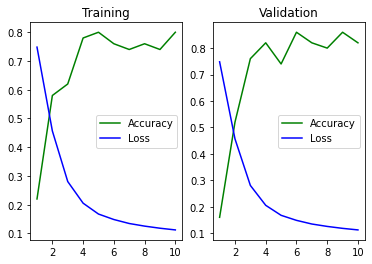

Count: 2, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 4184 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.22 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0282 - val loss:=0.0201, train acc:=0.54 - val acc:=0.56
# Epoch:=3/10  - train loss:=0.0183 - val loss:=0.0163, train acc:=0.68 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0124 - val loss:=0.0112, train acc:=0.70 - val acc:=0.74
# Epoch:=5/10  - train loss:=0.0101 - val loss:=0.0095, train acc:=0.82 - val acc:=0.74
# Epoch:=6/10  - train loss:=0.0089 - val loss:=0.0092, train acc:=0.72 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0082 - val loss:=0.0085, train acc:=0.82 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0076 - val loss:=0.0082, train acc:=0.82 - val acc:=0.88
# Epoch:=9/10  - train loss:=0.0072 - val loss:=0.0078, train acc:=0.76 - val acc:=0.84
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0075, train acc:=0.84 - val acc:=0.82

Total time taken

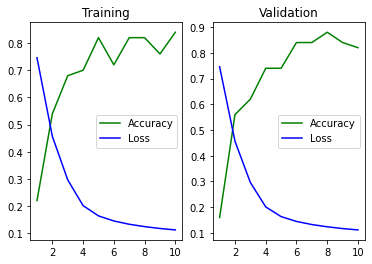

Count: 3, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 2626 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.18 - val acc:=0.28
# Epoch:=2/10  - train loss:=0.0270 - val loss:=0.0194, train acc:=0.54 - val acc:=0.58
# Epoch:=3/10  - train loss:=0.0158 - val loss:=0.0135, train acc:=0.68 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0124 - val loss:=0.0107, train acc:=0.78 - val acc:=0.80
# Epoch:=5/10  - train loss:=0.0102 - val loss:=0.0093, train acc:=0.72 - val acc:=0.84
# Epoch:=6/10  - train loss:=0.0091 - val loss:=0.0095, train acc:=0.80 - val acc:=0.74
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0084, train acc:=0.80 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0077 - val loss:=0.0088, train acc:=0.78 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0072 - val loss:=0.0080, train acc:=0.84 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0079, train acc:=0.82 - val acc:=0.80

Total time taken

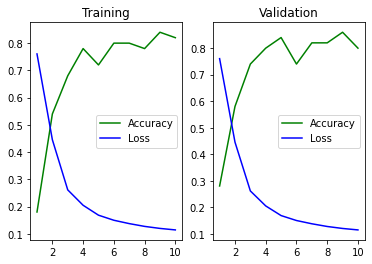

Count: 4, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 2644 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.14 - val acc:=0.18
# Epoch:=2/10  - train loss:=0.0269 - val loss:=0.0194, train acc:=0.52 - val acc:=0.62
# Epoch:=3/10  - train loss:=0.0155 - val loss:=0.0142, train acc:=0.70 - val acc:=0.66
# Epoch:=4/10  - train loss:=0.0124 - val loss:=0.0116, train acc:=0.74 - val acc:=0.70
# Epoch:=5/10  - train loss:=0.0106 - val loss:=0.0100, train acc:=0.74 - val acc:=0.78
# Epoch:=6/10  - train loss:=0.0095 - val loss:=0.0090, train acc:=0.74 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0085 - val loss:=0.0090, train acc:=0.78 - val acc:=0.76
# Epoch:=8/10  - train loss:=0.0079 - val loss:=0.0081, train acc:=0.80 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0074 - val loss:=0.0079, train acc:=0.82 - val acc:=0.90
# Epoch:=10/10  - train loss:=0.0070 - val loss:=0.0076, train acc:=0.82 - val acc:=0.88

Total time taken

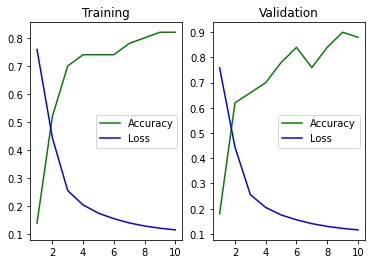

Count: 5, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 4608 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.12 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0308 - val loss:=0.0234, train acc:=0.46 - val acc:=0.54
# Epoch:=3/10  - train loss:=0.0163 - val loss:=0.0138, train acc:=0.68 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0126 - val loss:=0.0115, train acc:=0.74 - val acc:=0.84
# Epoch:=5/10  - train loss:=0.0105 - val loss:=0.0100, train acc:=0.78 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0092 - val loss:=0.0095, train acc:=0.72 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0089, train acc:=0.76 - val acc:=0.88
# Epoch:=8/10  - train loss:=0.0077 - val loss:=0.0080, train acc:=0.72 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0084, train acc:=0.82 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0070 - val loss:=0.0091, train acc:=0.78 - val acc:=0.74

Total time taken

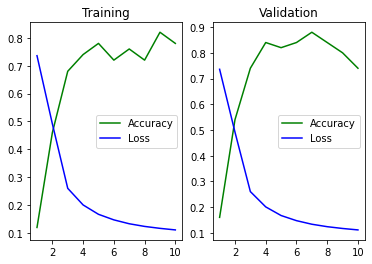

Count: 6, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 4127 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0441, train acc:=0.24 - val acc:=0.22
# Epoch:=2/10  - train loss:=0.0261 - val loss:=0.0201, train acc:=0.46 - val acc:=0.50
# Epoch:=3/10  - train loss:=0.0171 - val loss:=0.0134, train acc:=0.70 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0127 - val loss:=0.0112, train acc:=0.70 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0102 - val loss:=0.0096, train acc:=0.74 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0090 - val loss:=0.0091, train acc:=0.72 - val acc:=0.80
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0081, train acc:=0.68 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0077 - val loss:=0.0078, train acc:=0.76 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0072 - val loss:=0.0079, train acc:=0.78 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0073, train acc:=0.80 - val acc:=0.92

Total time taken

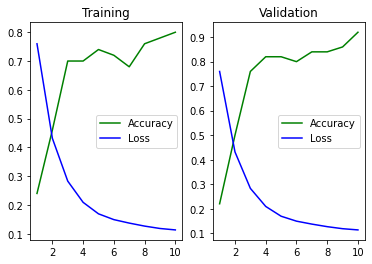

Count: 7, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 3327 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0450, train acc:=0.18 - val acc:=0.22
# Epoch:=2/10  - train loss:=0.0265 - val loss:=0.0197, train acc:=0.58 - val acc:=0.60
# Epoch:=3/10  - train loss:=0.0166 - val loss:=0.0148, train acc:=0.68 - val acc:=0.70
# Epoch:=4/10  - train loss:=0.0124 - val loss:=0.0108, train acc:=0.78 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0101 - val loss:=0.0093, train acc:=0.76 - val acc:=0.88
# Epoch:=6/10  - train loss:=0.0091 - val loss:=0.0088, train acc:=0.84 - val acc:=0.82
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0085, train acc:=0.82 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0081, train acc:=0.86 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0091, train acc:=0.76 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0076, train acc:=0.76 - val acc:=0.86

Total time taken

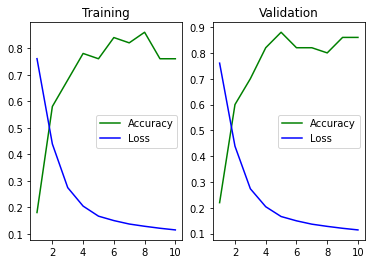

Count: 8, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 7689 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.20 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0293 - val loss:=0.0197, train acc:=0.56 - val acc:=0.56
# Epoch:=3/10  - train loss:=0.0168 - val loss:=0.0185, train acc:=0.72 - val acc:=0.78
# Epoch:=4/10  - train loss:=0.0126 - val loss:=0.0109, train acc:=0.74 - val acc:=0.86
# Epoch:=5/10  - train loss:=0.0105 - val loss:=0.0096, train acc:=0.74 - val acc:=0.88
# Epoch:=6/10  - train loss:=0.0092 - val loss:=0.0094, train acc:=0.72 - val acc:=0.80
# Epoch:=7/10  - train loss:=0.0084 - val loss:=0.0091, train acc:=0.80 - val acc:=0.86
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0082, train acc:=0.76 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0074 - val loss:=0.0079, train acc:=0.82 - val acc:=0.84
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0079, train acc:=0.78 - val acc:=0.80

Total time taken

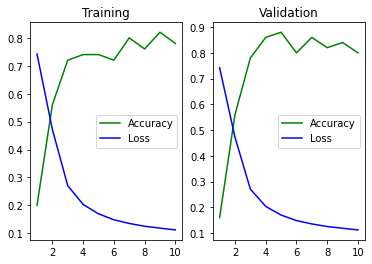

Count: 9, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 2155 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0457, train acc:=0.22 - val acc:=0.20
# Epoch:=2/10  - train loss:=0.0280 - val loss:=0.0203, train acc:=0.54 - val acc:=0.56
# Epoch:=3/10  - train loss:=0.0169 - val loss:=0.0176, train acc:=0.50 - val acc:=0.70
# Epoch:=4/10  - train loss:=0.0126 - val loss:=0.0111, train acc:=0.80 - val acc:=0.76
# Epoch:=5/10  - train loss:=0.0102 - val loss:=0.0092, train acc:=0.80 - val acc:=0.88
# Epoch:=6/10  - train loss:=0.0090 - val loss:=0.0085, train acc:=0.76 - val acc:=0.86
# Epoch:=7/10  - train loss:=0.0082 - val loss:=0.0095, train acc:=0.74 - val acc:=0.78
# Epoch:=8/10  - train loss:=0.0076 - val loss:=0.0079, train acc:=0.86 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0074, train acc:=0.80 - val acc:=0.88
# Epoch:=10/10  - train loss:=0.0069 - val loss:=0.0076, train acc:=0.80 - val acc:=0.78

Total time taken

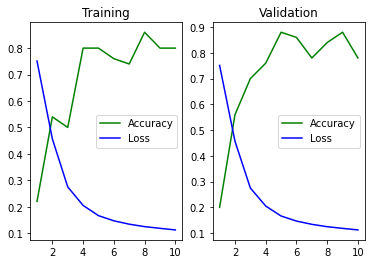

Count: 0, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 6080 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.14
# Epoch:=2/10  - train loss:=0.0326 - val loss:=0.0195, train acc:=0.58 - val acc:=0.54
# Epoch:=3/10  - train loss:=0.0166 - val loss:=0.0138, train acc:=0.70 - val acc:=0.78
# Epoch:=4/10  - train loss:=0.0126 - val loss:=0.0117, train acc:=0.68 - val acc:=0.74
# Epoch:=5/10  - train loss:=0.0104 - val loss:=0.0101, train acc:=0.72 - val acc:=0.78
# Epoch:=6/10  - train loss:=0.0092 - val loss:=0.0095, train acc:=0.82 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0085 - val loss:=0.0092, train acc:=0.80 - val acc:=0.74
# Epoch:=8/10  - train loss:=0.0079 - val loss:=0.0083, train acc:=0.80 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0075 - val loss:=0.0082, train acc:=0.80 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0071 - val loss:=0.0077, train acc:=0.76 - val acc:=0.84

Total time tak

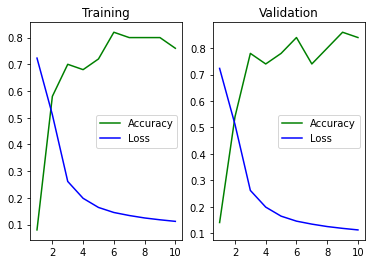

Count: 1, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 2229 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0456, train acc:=0.20 - val acc:=0.20
# Epoch:=2/10  - train loss:=0.0272 - val loss:=0.0207, train acc:=0.48 - val acc:=0.46
# Epoch:=3/10  - train loss:=0.0178 - val loss:=0.0178, train acc:=0.68 - val acc:=0.66
# Epoch:=4/10  - train loss:=0.0130 - val loss:=0.0115, train acc:=0.74 - val acc:=0.76
# Epoch:=5/10  - train loss:=0.0107 - val loss:=0.0109, train acc:=0.74 - val acc:=0.80
# Epoch:=6/10  - train loss:=0.0095 - val loss:=0.0092, train acc:=0.78 - val acc:=0.80
# Epoch:=7/10  - train loss:=0.0087 - val loss:=0.0093, train acc:=0.74 - val acc:=0.80
# Epoch:=8/10  - train loss:=0.0081 - val loss:=0.0088, train acc:=0.80 - val acc:=0.80
# Epoch:=9/10  - train loss:=0.0076 - val loss:=0.0081, train acc:=0.82 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0073 - val loss:=0.0078, train acc:=0.82 - val acc:=0.86

Total time tak

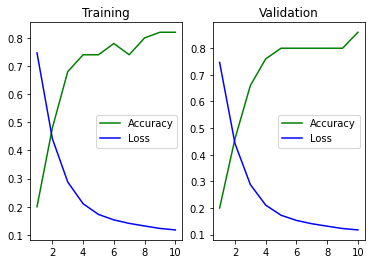

Count: 2, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 4663 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.22 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0301 - val loss:=0.0214, train acc:=0.56 - val acc:=0.56
# Epoch:=3/10  - train loss:=0.0180 - val loss:=0.0159, train acc:=0.66 - val acc:=0.76
# Epoch:=4/10  - train loss:=0.0127 - val loss:=0.0124, train acc:=0.70 - val acc:=0.82
# Epoch:=5/10  - train loss:=0.0103 - val loss:=0.0103, train acc:=0.74 - val acc:=0.84
# Epoch:=6/10  - train loss:=0.0092 - val loss:=0.0098, train acc:=0.78 - val acc:=0.82
# Epoch:=7/10  - train loss:=0.0085 - val loss:=0.0087, train acc:=0.78 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0079 - val loss:=0.0080, train acc:=0.80 - val acc:=0.90
# Epoch:=9/10  - train loss:=0.0075 - val loss:=0.0083, train acc:=0.78 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0072 - val loss:=0.0077, train acc:=0.80 - val acc:=0.80

Total time tak

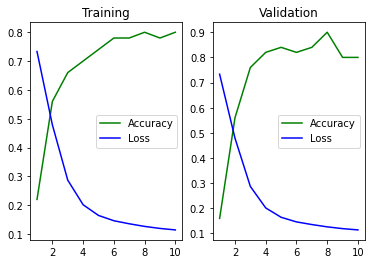

Count: 3, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 5635 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0459, train acc:=0.08 - val acc:=0.16
# Epoch:=2/10  - train loss:=0.0299 - val loss:=0.0275, train acc:=0.42 - val acc:=0.46
# Epoch:=3/10  - train loss:=0.0161 - val loss:=0.0138, train acc:=0.68 - val acc:=0.84
# Epoch:=4/10  - train loss:=0.0125 - val loss:=0.0121, train acc:=0.76 - val acc:=0.80
# Epoch:=5/10  - train loss:=0.0105 - val loss:=0.0102, train acc:=0.78 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0092 - val loss:=0.0090, train acc:=0.76 - val acc:=0.78
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0082, train acc:=0.82 - val acc:=0.92
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0078, train acc:=0.74 - val acc:=0.88
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0077, train acc:=0.76 - val acc:=0.88
# Epoch:=10/10  - train loss:=0.0070 - val loss:=0.0075, train acc:=0.80 - val acc:=0.88

Total time tak

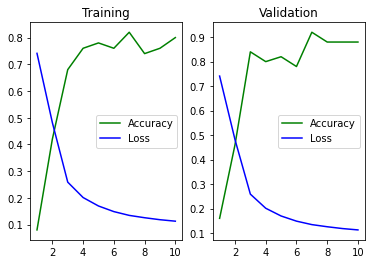

Count: 4, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 6913 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0453, train acc:=0.14 - val acc:=0.22
# Epoch:=2/10  - train loss:=0.0270 - val loss:=0.0295, train acc:=0.38 - val acc:=0.42
# Epoch:=3/10  - train loss:=0.0156 - val loss:=0.0141, train acc:=0.64 - val acc:=0.66
# Epoch:=4/10  - train loss:=0.0123 - val loss:=0.0123, train acc:=0.74 - val acc:=0.70
# Epoch:=5/10  - train loss:=0.0105 - val loss:=0.0100, train acc:=0.80 - val acc:=0.80
# Epoch:=6/10  - train loss:=0.0093 - val loss:=0.0088, train acc:=0.78 - val acc:=0.80
# Epoch:=7/10  - train loss:=0.0084 - val loss:=0.0085, train acc:=0.76 - val acc:=0.82
# Epoch:=8/10  - train loss:=0.0078 - val loss:=0.0081, train acc:=0.80 - val acc:=0.86
# Epoch:=9/10  - train loss:=0.0074 - val loss:=0.0080, train acc:=0.80 - val acc:=0.82
# Epoch:=10/10  - train loss:=0.0071 - val loss:=0.0074, train acc:=0.78 - val acc:=0.88

Total time tak

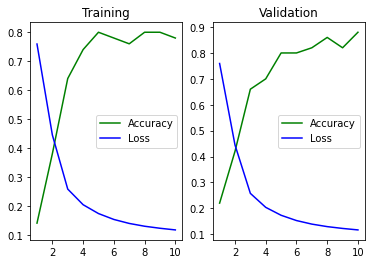

Count: 5, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 2608 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.12 - val acc:=0.10
# Epoch:=2/10  - train loss:=0.0283 - val loss:=0.0187, train acc:=0.54 - val acc:=0.52
# Epoch:=3/10  - train loss:=0.0156 - val loss:=0.0130, train acc:=0.62 - val acc:=0.78
# Epoch:=4/10  - train loss:=0.0125 - val loss:=0.0117, train acc:=0.76 - val acc:=0.86
# Epoch:=5/10  - train loss:=0.0107 - val loss:=0.0106, train acc:=0.74 - val acc:=0.82
# Epoch:=6/10  - train loss:=0.0095 - val loss:=0.0095, train acc:=0.80 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0087 - val loss:=0.0092, train acc:=0.80 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0081 - val loss:=0.0087, train acc:=0.80 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0076 - val loss:=0.0081, train acc:=0.82 - val acc:=0.82
# Epoch:=10/10  - train loss:=0.0073 - val loss:=0.0078, train acc:=0.82 - val acc:=0.84

Total time tak

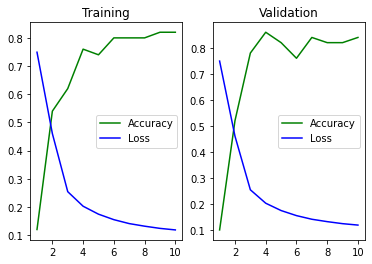

Count: 6, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 1775 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.08 - val acc:=0.14
# Epoch:=2/10  - train loss:=0.0296 - val loss:=0.0208, train acc:=0.56 - val acc:=0.46
# Epoch:=3/10  - train loss:=0.0174 - val loss:=0.0137, train acc:=0.62 - val acc:=0.74
# Epoch:=4/10  - train loss:=0.0125 - val loss:=0.0109, train acc:=0.74 - val acc:=0.84
# Epoch:=5/10  - train loss:=0.0104 - val loss:=0.0097, train acc:=0.84 - val acc:=0.86
# Epoch:=6/10  - train loss:=0.0093 - val loss:=0.0094, train acc:=0.70 - val acc:=0.82
# Epoch:=7/10  - train loss:=0.0085 - val loss:=0.0091, train acc:=0.70 - val acc:=0.80
# Epoch:=8/10  - train loss:=0.0079 - val loss:=0.0108, train acc:=0.72 - val acc:=0.78
# Epoch:=9/10  - train loss:=0.0074 - val loss:=0.0078, train acc:=0.84 - val acc:=0.84
# Epoch:=10/10  - train loss:=0.0071 - val loss:=0.0082, train acc:=0.80 - val acc:=0.84

Total time tak

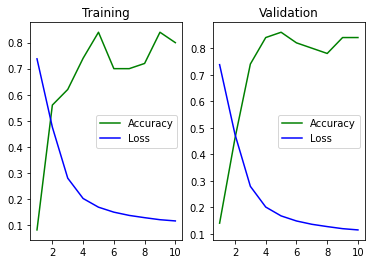

Count: 7, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 5384 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.10 - val acc:=0.14
# Epoch:=2/10  - train loss:=0.0295 - val loss:=0.0195, train acc:=0.62 - val acc:=0.54
# Epoch:=3/10  - train loss:=0.0149 - val loss:=0.0145, train acc:=0.66 - val acc:=0.62
# Epoch:=4/10  - train loss:=0.0119 - val loss:=0.0105, train acc:=0.72 - val acc:=0.66
# Epoch:=5/10  - train loss:=0.0101 - val loss:=0.0100, train acc:=0.78 - val acc:=0.80
# Epoch:=6/10  - train loss:=0.0090 - val loss:=0.0087, train acc:=0.78 - val acc:=0.86
# Epoch:=7/10  - train loss:=0.0083 - val loss:=0.0087, train acc:=0.78 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0077 - val loss:=0.0081, train acc:=0.78 - val acc:=0.86
# Epoch:=9/10  - train loss:=0.0073 - val loss:=0.0088, train acc:=0.80 - val acc:=0.90
# Epoch:=10/10  - train loss:=0.0070 - val loss:=0.0076, train acc:=0.86 - val acc:=0.84

Total time tak

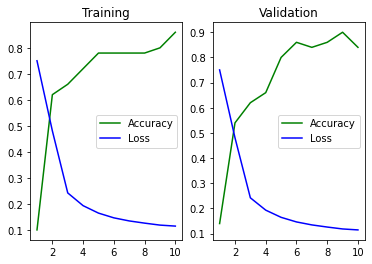

Count: 8, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 3485 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0460, train acc:=0.12 - val acc:=0.12
# Epoch:=2/10  - train loss:=0.0296 - val loss:=0.0185, train acc:=0.62 - val acc:=0.62
# Epoch:=3/10  - train loss:=0.0157 - val loss:=0.0133, train acc:=0.64 - val acc:=0.80
# Epoch:=4/10  - train loss:=0.0125 - val loss:=0.0111, train acc:=0.68 - val acc:=0.84
# Epoch:=5/10  - train loss:=0.0105 - val loss:=0.0100, train acc:=0.78 - val acc:=0.84
# Epoch:=6/10  - train loss:=0.0092 - val loss:=0.0092, train acc:=0.78 - val acc:=0.82
# Epoch:=7/10  - train loss:=0.0085 - val loss:=0.0085, train acc:=0.80 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0079 - val loss:=0.0084, train acc:=0.78 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0075 - val loss:=0.0083, train acc:=0.84 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0071 - val loss:=0.0081, train acc:=0.82 - val acc:=0.82

Total time tak

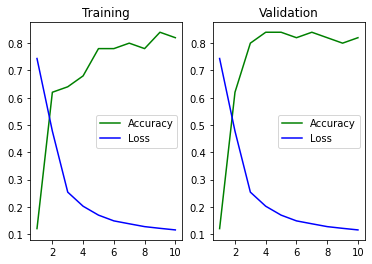

Count: 9, j=: 1


**************** Training model: mlp_on_gpu_RegL1L2 with seed: 9948 ****************

# Epoch:=1/10  - train loss:=0.0460 - val loss:=0.0458, train acc:=0.26 - val acc:=0.24
# Epoch:=2/10  - train loss:=0.0279 - val loss:=0.0208, train acc:=0.56 - val acc:=0.56
# Epoch:=3/10  - train loss:=0.0176 - val loss:=0.0133, train acc:=0.70 - val acc:=0.84
# Epoch:=4/10  - train loss:=0.0127 - val loss:=0.0117, train acc:=0.72 - val acc:=0.80
# Epoch:=5/10  - train loss:=0.0106 - val loss:=0.0101, train acc:=0.80 - val acc:=0.86
# Epoch:=6/10  - train loss:=0.0093 - val loss:=0.0100, train acc:=0.78 - val acc:=0.76
# Epoch:=7/10  - train loss:=0.0085 - val loss:=0.0092, train acc:=0.82 - val acc:=0.80
# Epoch:=8/10  - train loss:=0.0079 - val loss:=0.0085, train acc:=0.82 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0075 - val loss:=0.0096, train acc:=0.76 - val acc:=0.80
# Epoch:=10/10  - train loss:=0.0071 - val loss:=0.0087, train acc:=0.80 - val acc:=0.82

Total time tak

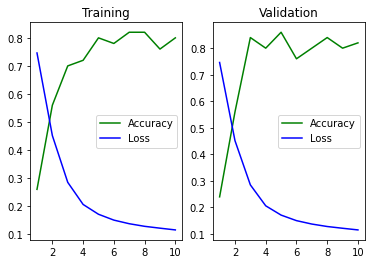

In [6]:
if __name__ == "__main__":
    mnist, fashion_mnist = main()

In [8]:
# %store mnist
# %store fashion_mnist

In [9]:
for names in mnist:
    print(mnist[names]['Accuracy'])

[96.29299999999999, 0.050861000000000066]
[96.271, 0.07446899999999937]
[96.25899999999999, 0.06194899999999949]
[96.35799999999999, 0.07139599999999971]


In [11]:
for names in fashion_mnist:
    print(fashion_mnist[names]['Accuracy'])

[85.288, 0.42821599999999754]
[85.545, 0.15834499999999863]
[85.135, 0.749665000000002]
[84.87199999999999, 0.6454960000000004]


In [ ]:
import pickle
pic